# Logistic Regression (Assignment)

## Data Lit

1. Apply sklearn or your favorite ML library’s inbuilt logistic regression model for prediction.
2. In this assignment, you are expected to implement logistic regression and get a good understanding of the key components of logistic  regression:
  * hypothesis function
  * cost function
  * decision boundary
  * gradient descent algorithm

Finally, compare the result you got from built-in model versus your own implementation on various metrics.

### Dependencies

In [0]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline
warnings.filterwarnings("ignore")

### Upload Kaggle json

In [2]:
#@title
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


### Download and unzip competition files

In [3]:
#@title
!kaggle datasets download -d johnolafenwa/us-census-data

  0% 0.00/719k [00:00<?, ?B/s]
100% 719k/719k [00:00<00:00, 43.5MB/s]


In [4]:
#@title
!unzip us-census-data.zip
!ls

Archive:  us-census-data.zip
  inflating: adult-test.csv          
  inflating: adult-training.csv      
adult-test.csv	adult-training.csv  sample_data  us-census-data.zip


### Load data sets

In [0]:
columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']

numerical_cols = ['Age','fnlgwt','Education num','Capital Gain','Capital Loss', 'Hours/Week']

categorical_cols = ['Workclass','Education','Marital Status', 'Occupation',
                    'Relationship','Race','Sex','Native country']

X_train = pd.read_csv('adult-training.csv', names=columns)
X_val = pd.read_csv('adult-test.csv', names=columns, skiprows=1)

X_train['Income'] = X_train['Income'].apply(lambda x: 1 if x==' >50K' else 0)
X_val['Income'] = X_val['Income'].apply(lambda x: 1 if x==' >50K.' else 0)

Y_train = X_train['Income'].values
Y_val = X_val['Income'].values
X_train.drop('Income', axis=1, inplace=True)
X_val.drop('Income', axis=1, inplace=True)

### Train raw data

In [6]:
print('Train set shape:', X_train.shape)
display(X_train.head())
display(X_train[numerical_cols].describe().T)
display(X_train[categorical_cols].describe().T)

Train set shape: (32561, 14)


,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


,count,mean,std,min,25%,50%,75%,max
Age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlgwt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
Education num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
Capital Gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
Capital Loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
Hours/Week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


,count,unique,top,freq
Workclass,32561,9,Private,22696
Education,32561,16,HS-grad,10501
Marital Status,32561,7,Married-civ-spouse,14976
Occupation,32561,15,Prof-specialty,4140
Relationship,32561,6,Husband,13193
Race,32561,5,White,27816
Sex,32561,2,Male,21790
Native country,32561,42,United-States,29170


### Test raw data

In [7]:
print('Test set shape:', X_val.shape)
display(X_val.head())
display(X_val[numerical_cols].describe().T)
display(X_val[categorical_cols].describe().T)

Test set shape: (16281, 14)


,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlgwt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
Hours/Week,16281.0,40.392236,12.479332,1.0,40.0,40.0,45.0,99.0


,count,unique,top,freq
Workclass,16281,9,Private,11210
Education,16281,16,HS-grad,5283
Marital Status,16281,7,Married-civ-spouse,7403
Occupation,16281,15,Prof-specialty,2032
Relationship,16281,6,Husband,6523
Race,16281,5,White,13946
Sex,16281,2,Male,10860
Native country,16281,41,United-States,14662


### Process categorical features

In [0]:
for feature in categorical_cols:
  le = LabelEncoder()
  X_train[feature] = le.fit_transform(X_train[feature])
  X_val[feature] = le.transform(X_val[feature])

### Normalize using Min-Max scaling

In [0]:
minMax_scaler = MinMaxScaler()
X_train = minMax_scaler.fit_transform(X_train)
X_val = minMax_scaler.transform(X_val)

### SkLearn Logisti Regression

In [10]:
sk_model = LogisticRegression(random_state=0)
sk_model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
sk_train_predictions = sk_model.predict(X_train)
sk_test_predictions = sk_model.predict(X_val)

### Logistic Regression implementation

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def initialize_with_zeros(dim):
    w = np.random.randn(dim, 1) * 0.01
    b = 0
    return w, b


def propagate(w, b, X, Y):
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    # compute activation
    Y*np.log(A)
    cost = (-1/m)*np.sum((Y*np.log(A))+(1-Y)*(np.log(1-A)))         # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)

    cost = np.squeeze(cost)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
    
    return Y_prediction


def train(X_train, Y_train, X_test, Y_test, num_iterations=100, learning_rate=0.001, print_cost=True):
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_train" : Y_prediction_train, 
         "Y_prediction_test": Y_prediction_test, 
         "w" : w, 
         "b" : b}
    
    return d

In [0]:
# Resampling test and train set
X_train_sampled = X_train[:2000]
Y_train_sampled = Y_train[:2000]

X_val_sampled = X_val[:2000]
Y_val_sampled = Y_val[:2000]

In [14]:
model = train(X_train_sampled, Y_train_sampled.reshape(Y_train_sampled.shape[0], 1), X_val_sampled, Y_val_sampled.reshape(Y_val_sampled.shape[0], 1), 1000, 0.001)

Cost after iteration 0: 1387.126933
Cost after iteration 100: 227.618628
Cost after iteration 200: 191.016574
Cost after iteration 300: 172.589920
Cost after iteration 400: 160.030436
Cost after iteration 500: 150.332065
Cost after iteration 600: 142.335971
Cost after iteration 700: 135.480930
Cost after iteration 800: 129.453704
Cost after iteration 900: 124.061394
train accuracy: 75.05 %
test accuracy: 75.95 %


## Model comparison

### SKLearn model

In [15]:
#@title
print('-----Train-----')
print(classification_report(Y_train, sk_train_predictions))
print('-----Test-----')
print(classification_report(Y_val, sk_test_predictions))

-----Train-----
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     24720
           1       0.71      0.44      0.55      7841

   micro avg       0.82      0.82      0.82     32561
   macro avg       0.78      0.69      0.72     32561
weighted avg       0.81      0.82      0.81     32561

-----Test-----
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     12435
           1       0.70      0.43      0.54      3846

   micro avg       0.82      0.82      0.82     16281
   macro avg       0.77      0.69      0.71     16281
weighted avg       0.81      0.82      0.81     16281



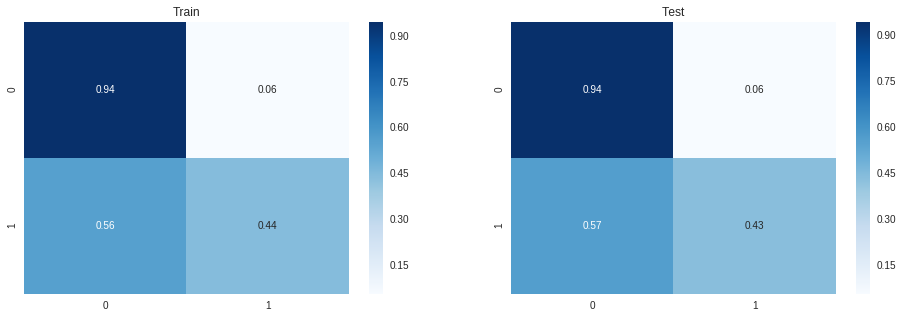

In [16]:
#@title
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, sk_train_predictions)
test_cnf_matrix = confusion_matrix(Y_val, sk_test_predictions)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=axes[1]).set_title("Test")

plt.show()